To create sample images SIMLAN/camera_utility/camera_data
```
./control.sh camera_dump

```
Relavant files: 

```
# to enable k1,k2,k3
simulation/static_agent_launcher/description/camera_macros.xacro
update camera config for gazebo
simulation/static_agent_launcher/description/camera_config.xacro
```

# Loading images and calibration files

In [54]:
import numpy as np
import math
import cv2
import numpy
import calibration
import glob
from IPython.display import Image
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
cameras = range(160,170)
images_path = []
images_calib = []  # f~2218, w~1936*2 , h~1091*2
images_raw = []
for cam in cameras:
    name = f"{cam}.yaml"
    intrinsic_yaml_file = "intrinsic/" + name
    extrinsic_yaml_file = "extrinsic/" + name
    calib = calibration.Camera_config(intrinsic_yaml_file, extrinsic_yaml_file, name)
    filepattern = "camera_data/" + str(cam) + "/" + "*"
    images_calib.append(calib)
    image_path = glob.glob("camera_data/" + str(cam) + "/" + "*" )[0]
    images_path.append(image_path)
    images_raw.append(mpimg.imread(image_path)[:,:,0])


print(len(images_raw[0]))
print(images_path)
print("Number of cameras image path and calibration file paths (should be equal)",len(images_calib), len(images_path))

2160
['camera_data/160/raw_1761309003_160_.png', 'camera_data/161/raw_1761309007_161_.png', 'camera_data/162/raw_1761309012_162_.png', 'camera_data/163/raw_1761309003_163_.png', 'camera_data/164/raw_1761309012_164_.png', 'camera_data/165/raw_1761309019_165_.png', 'camera_data/166/raw_1761309019_166_.png', 'camera_data/167/raw_1761309004_167_.png', 'camera_data/168/raw_1761309011_168_.png', 'camera_data/169/raw_1761309011_169_.png']
Number of cameras image path and calibration file paths (should be equal) 10 10


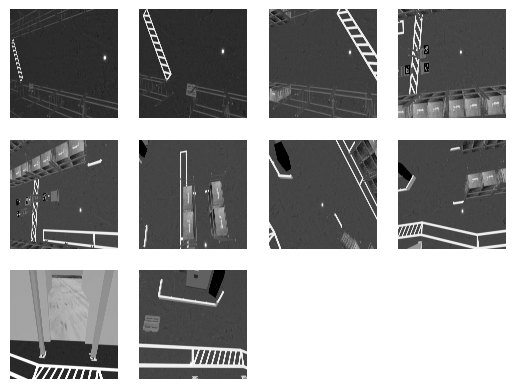

In [55]:
fig = plt.figure()
INDEX = 0 

for INDEX in range(0,len(cameras)):
    ax = fig.add_subplot(3,4,INDEX + 1)
    ax.imshow(images_raw[INDEX], cmap='gray')
    ax.axis("off")
    plt.axis("tight")

# Grid of points in the world

In [56]:
# individual points
# Pw = np.array(np.meshgrid([0,1,2], [0,1,2], [0], [1])).reshape(4,-1)

# grid of points in the world
GRID_CENTER_X = 0
GRID_CENTER_Y = 1

GRID_RANGE = 5    # CHANGE ME, square shape grid ranges from -GRID_RANGE to +GRID_RANGE
STEP = 0.02       # CHANGE ME, resolution
Pw = np.array(np.meshgrid(np.arange(GRID_CENTER_X + (-1 * GRID_RANGE) , GRID_CENTER_X + ( 1 * GRID_RANGE ) +0.001, step=STEP), np.arange(GRID_CENTER_Y + (-1 * GRID_RANGE) , GRID_CENTER_Y + ( 1 * GRID_RANGE ) +0.001, step=STEP), [0], [1])).reshape(4,-1)
gridsize = len(np.arange(-1 * GRID_RANGE, GRID_RANGE+0.001, step=STEP))

print(gridsize)
print(Pw.shape)
print(Pw)

501
(4, 251001)
[[-5.   -4.98 -4.96 ...  4.96  4.98  5.  ]
 [-4.   -4.   -4.   ...  6.    6.    6.  ]
 [ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 1.    1.    1.   ...  1.    1.    1.  ]]


# Project points in the grid (world) to camera coordinates
https://github.com/polygon-software/python-visual-odometry/blob/master/Chapter%203%20-%20Camera%20Projection.ipynb

In [57]:
from functools import partial

def undistortPoint(point, D):
    """
    Shifts a point in Camera normalized camera coordinates to new position according to distortion factor D
    :param Tuple[x,y,1] point:  Undistorted point with x,y,1 coordinates in camera frame
    :param Tuple[dx, dy] D:     Distortion factor in x and y direction 
    :return: Distorted point
    :rtype: Tuple[x,y,1]
    """
    dist_x, dist_y = D[0], D[1]
    
    # r^2 = (x^2 + y^2)
    r_squared = point[0] ** 2 + point[1] ** 2
    
    # Calculate undistortion
    point_undistorted = point * (1 + dist_x*r_squared + dist_y*r_squared**2)
    
    # Ensure that last factor is still 1
    point_undistorted[2] = 1
    
    # Return distorted value
    return point_undistorted


def inside_image(width, height, coordinates):
    # TODO: double check height and width order
    in_range = (coordinates[0] > 0) & (coordinates[0] < width) & \
               (coordinates[1] > 0) & (coordinates[1] < height)

    # Convert boolean result to an integer array (1 for True, 0 for False)
    in_range = in_range.astype(int)
    #print(height, width, coordinates, in_range)

    # Example: returning the difference between the two elements
    return in_range

def word2camera(indx, Pw):
    K= np.array(images_calib[indx].in_K).reshape(3, 3)   # f~2218, w~1936*2 , h~1091*2
    D= np.array(images_calib[indx].in_D)
    R = np.array(images_calib[indx].ex_rot_mat)
    t = np.array(images_calib[indx].ex_t_vec)
    T = np.concatenate((R, t), axis=1)
    # Project (Xw, Yw, Zw, 0) into cameras coordinate system
    Pc_distorted = np.matmul(T, Pw)

    Pc_norml = (Pc_distorted / Pc_distorted[2][0])

    
    # DECIDE : 
    #### distorted 
    Pc = undistortPoint(Pc_norml, D)
    p = np.matmul(K, Pc)
    
    #### not distorted 
    #p = np.matmul(K, Pc_norml)
    
    uv = p[:-1]
    inside_image_partial = partial(inside_image, images_calib[indx].width , images_calib[indx].height)
    #print(uv.shape)
    inside_column = np.apply_along_axis(inside_image_partial, axis=0, arr=uv)
    inside_column = inside_column.reshape(1, -1)
    new_uv = np.vstack([uv, inside_column])
    return new_uv

In [58]:
# convert Pw 3d world coordiantes to 2d camera coord
# returns a 3d python numpy.ndarray
# the first dimension is the camera index
# the second dimension has the size 3, two camera uv coordinates and inrange, whether the coords are in the camera image range
# the third dimension is the index into points in the image
uv_s = np.empty((len(images_calib), 3, Pw.shape[1]))

for i in range(len(images_calib)):
    uv_s[i] = word2camera(i, Pw)

uv_s shape: (3, 251001)
images_raw shape: (2160, 3840)


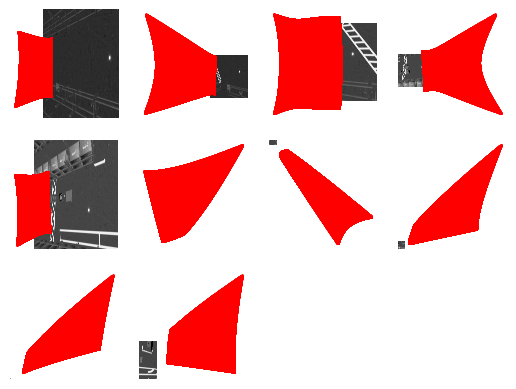

In [59]:
fig = plt.figure()
INDEX = 0 

for INDEX in range(0,len(images_calib)):
    ax = fig.add_subplot(3,4,INDEX + 1)
    ax.imshow(images_raw[INDEX], cmap='gray')
    ax.scatter(x=uv_s[INDEX][0], y=uv_s[INDEX][1], c='r', s=1)
    ax.axis("off")
    plt.axis("tight")
print("uv_s shape:", uv_s[0].shape)
print("images_raw shape:", images_raw[0].shape)

In [60]:
num_coords = uv_s[0].shape[1]
coords_color = np.zeros((len(images_calib),num_coords))
for img in range(len(images_calib)):
    image = uv_s[img].astype(int)
    for i in range(num_coords):
        x     = image[0,i]
        y     = image[1,i]
        valid = image[2,i]
        #print(x,y,valid)
        if valid:
            coords_color[img][i] = images_raw[img][y, x]
        else:
            coords_color[img][i] = 0

print(coords_color.shape)
print(num_coords)

(10, 251001)
251001


# Stitching Projected Images

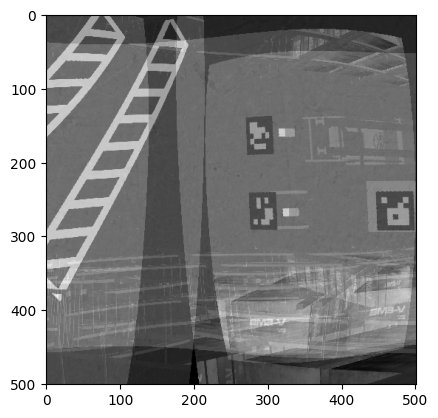

In [61]:
means = np.mean(coords_color, axis=0)
stich = means.reshape((gridsize,gridsize ))
plt.imshow(stich, cmap='gray')
plt.show()